In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
from PIL import Image
import random

# Thư viện deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Thư viện đánh giá
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


2025-05-21 12:45:41.049854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747831541.240205      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747831541.294146      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_data(data_dir):
    images_paths = []
    labels = []
    
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                if image_file.lower().endswith('.jpg'):
                    images_paths.append(os.path.join(label_dir, image_file))
                    labels.append(label)
    
    return images_paths, labels

data_dir = "/kaggle/input/rice-leaf-disease-image" 
    
images_paths, labels = load_data(data_dir)

In [3]:
IMAGE_SIZE = 224

def preprocess_image(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(img, target_size)
    
    img = img.astype('float32') / 255.0
    
    return img

In [4]:
SEED = 42

def split_data(images_paths, labels, val_size=0.25):
    
    # Chia tập train và test
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        images_paths, labels, test_size=val_size, stratify=labels, random_state=SEED
    )
    
    
    print(f"Tập huấn luyện: {len(train_paths)} ảnh")
    print(f"Tập xác thực: {len(val_paths)} ảnh")
    
    return train_paths, train_labels, val_paths, val_labels

In [5]:
train_paths, train_labels, val_paths, val_labels = split_data(images_paths, labels)

Tập huấn luyện: 4449 ảnh
Tập xác thực: 1483 ảnh


In [6]:
BATCH_SIZE = 32

def create_data_generators(train_paths, train_labels, val_paths, val_labels):
    
    # Ánh xạ nhãn văn bản thành số nguyên
    unique_labels = sorted(set(train_labels))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    
    # Chuyển đổi nhãn văn bản sang số nguyên
    train_labels_idx = [label_to_idx[label] for label in train_labels]
    val_labels_idx = [label_to_idx[label] for label in val_labels]
    
    # Tạo augmentation cho tập huấn luyện
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Không augmentation cho tập validation và test
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # Tạo các generator
    # Xây dựng hàm tạo dữ liệu
    def generate_data(paths, labels, batch_size, datagen, shuffle=True):
        num_samples = len(paths)
        while True:
            if shuffle:
                # Xáo trộn dữ liệu
                idx = np.random.permutation(num_samples)
                paths = [paths[i] for i in idx]
                labels = [labels[i] for i in idx]
            
            for start_idx in range(0, num_samples, batch_size):
                end_idx = min(start_idx + batch_size, num_samples)
                batch_paths = paths[start_idx:end_idx]
                batch_labels = labels[start_idx:end_idx]
                
                # Đọc và tiền xử lý ảnh
                batch_images = np.array([preprocess_image(path) for path in batch_paths])
                batch_labels_encoded = np.array(batch_labels)
                
                # Áp dụng augmentation
                if datagen is not None:
                    for x_batch, y_batch in datagen.flow(batch_images, batch_labels_encoded, batch_size=len(batch_images)):
                        yield x_batch, y_batch
                        break
                else:
                    yield batch_images, batch_labels_encoded
    
    train_gen = generate_data(train_paths, train_labels_idx, BATCH_SIZE, train_datagen)
    val_gen = generate_data(val_paths, val_labels_idx, BATCH_SIZE, None, shuffle=False)
    
    return train_gen, val_gen, label_to_idx


train_gen, val_gen, label_to_idx = create_data_generators(
        train_paths, train_labels, val_paths, val_labels
    )

In [7]:
def plot_training_history(history):

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [8]:
from functools import partial 

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
# model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4, activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747790855.285947      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [9]:
from tensorflow.keras.optimizers import Nadam

optimizer = Nadam(learning_rate=0.0001)  
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 64)        │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit (ResidualUnit)         │ (None, 56, 56, 64)          │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_1 (ResidualUnit)       │ (None, 56, 56, 64)          │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_2 (ResidualUnit)       │ (None, 56, 56, 64)          │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_3 (ResidualUnit)       │ (None, 28, 28, 128)         │         230,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_4 (ResidualUnit)       │ (None, 28, 28, 128)         │         295,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_5 (ResidualUnit)       │ (None, 28, 28, 128)         │         295,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_6 (ResidualUnit)       │ (None, 28, 28, 128)         │         295,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_7 (ResidualUnit)       │ (None, 14, 14, 256)         │         920,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_8 (ResidualUnit)       │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_9 (ResidualUnit)       │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_10 (ResidualUnit)      │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_11 (ResidualUnit)      │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_12 (ResidualUnit)      │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_13 (ResidualUnit)      │ (None, 7, 7, 512)           │       3,676,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_14 (ResidualUnit)      │ (None, 7, 7, 512)           │       4,722,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_15 (ResidualUnit)      │ (None, 7, 7, 512)           │       4,722,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │              

 Total params: 21,303,748 (81.27 MB)

 Trainable params: 21,286,724 (81.20 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [11]:
EPOCHS = 40

checkpoint = ModelCheckpoint(
        'bestmodel_resnet34.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
    )
early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
    
steps_per_epoch = len(train_paths) // BATCH_SIZE
validation_steps = len(val_paths) // BATCH_SIZE
    
steps_per_epoch = max(1, steps_per_epoch)
validation_steps = max(1, validation_steps)
    
history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_gen,
        validation_steps=validation_steps,
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )

Epoch 1/40


I0000 00:00:1747790895.953406      98 service.cc:148] XLA service 0x7ab1c4001fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747790895.954254      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747790898.352442      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:43:10 45s/step - accuracy: 0.1250 - loss: 3.7332

I0000 00:00:1747790908.795503      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.6678 - loss: 1.0554
Epoch 1: val_accuracy improved from -inf to 0.26970, saving model to bestmodel_resnet34.h5
139/139 ━━━━━━━━━━━━━━━━━━━━ 160s 835ms/step - accuracy: 0.6686 - loss: 1.0526 - val_accuracy: 0.2697 - val_loss: 5.0848 - learning_rate: 1.0000e-04
Epoch 2/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8644 - loss: 0.3743
Epoch 2: val_accuracy did not improve from 0.26970
139/139 ━━━━━━━━━━━━━━━━━━━━ 67s 421ms/step - accuracy: 0.8645 - loss: 0.3740 - val_accuracy: 0.2079 - val_loss: 4.7693 - learning_rate: 1.0000e-04
Epoch 3/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9031 - loss: 0.2642
Epoch 3: val_accuracy improved from 0.26970 to 0.66440, saving model to bestmodel_resnet34.h5
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 423ms/step - accuracy: 0.9032 - loss: 0.2639 - val_accuracy: 0.6644 - val_loss: 1.2039 - learning_rate: 1.0000e-04
Epoch 4/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 

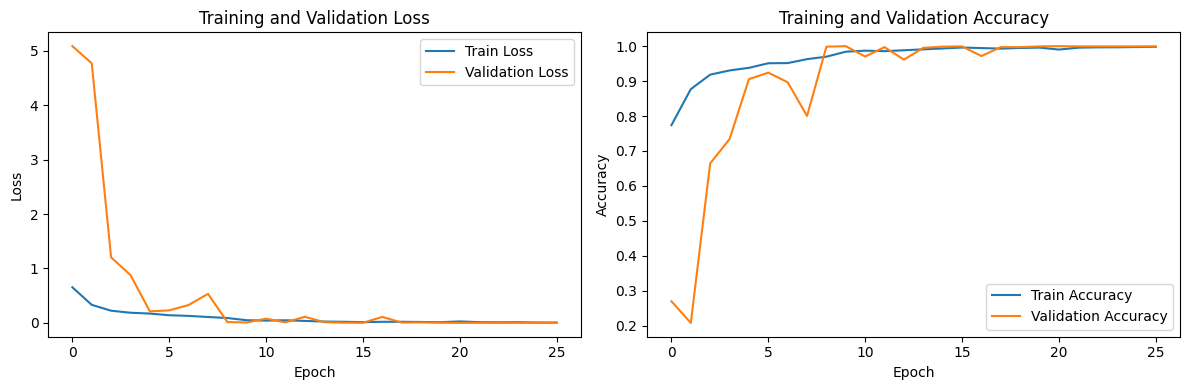

In [12]:
plot_training_history(history)

# Sử dụng Pre-trained

In [7]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x) 
predictions = keras.layers.Dense(4, activation='softmax')(x)

model2 = models.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

I0000 00:00:1747831554.595140      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
from tensorflow.keras.optimizers import Nadam
optimizer = Nadam(learning_rate=0.003)
model2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [9]:
model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
checkpoint = ModelCheckpoint(
    'bestmodel_resnet50.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# Tính số bước cho mỗi epoch
steps_per_epoch = len(train_paths) // BATCH_SIZE
validation_steps = len(val_paths) // BATCH_SIZE

steps_per_epoch = max(1, steps_per_epoch)
validation_steps = max(1, validation_steps)

In [11]:
history_stage1 = model2.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=20,  
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/20


I0000 00:00:1747831569.297014      95 service.cc:148] XLA service 0x7f8ea0004230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747831569.298354      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747831570.702716      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/139 ━━━━━━━━━━━━━━━━━━━━ 33:36 15s/step - accuracy: 0.3125 - loss: 1.7489

I0000 00:00:1747831574.114337      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.3725 - loss: 1.3327
Epoch 1: val_accuracy improved from -inf to 0.55707, saving model to bestmodel_resnet50.h5
139/139 ━━━━━━━━━━━━━━━━━━━━ 119s 756ms/step - accuracy: 0.3728 - loss: 1.3321 - val_accuracy: 0.5571 - val_loss: 1.2147 - learning_rate: 0.0030
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.4607 - loss: 1.2038
Epoch 2: val_accuracy did not improve from 0.55707
139/139 ━━━━━━━━━━━━━━━━━━━━ 60s 412ms/step - accuracy: 0.4608 - loss: 1.2036 - val_accuracy: 0.5360 - val_loss: 1.1406 - learning_rate: 0.0030
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.5172 - loss: 1.1393
Epoch 3: val_accuracy improved from 0.55707 to 0.57541, saving model to bestmodel_resnet50.h5
139/139 ━━━━━━━━━━━━━━━━━━━━ 58s 419ms/step - accuracy: 0.5173 - loss: 1.1392 - val_accuracy: 0.5754 - val_loss: 1.1362 - learning_rate: 0.0030
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.5334 - los

In [12]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = Nadam(learning_rate=0.0001)  
model2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history_stage2 = model2.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=25, 
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.6396 - loss: 18.8169
Epoch 1: val_accuracy did not improve from 0.67402
139/139 ━━━━━━━━━━━━━━━━━━━━ 166s 587ms/step - accuracy: 0.6409 - loss: 18.7229 - val_accuracy: 0.2688 - val_loss: 140.8130 - learning_rate: 1.0000e-04
Epoch 2/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9553 - loss: 0.3209
Epoch 2: val_accuracy did not improve from 0.67402
139/139 ━━━━━━━━━━━━━━━━━━━━ 58s 416ms/step - accuracy: 0.9553 - loss: 0.3204 - val_accuracy: 0.2419 - val_loss: 26.4757 - learning_rate: 1.0000e-04
Epoch 3/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9762 - loss: 0.0938
Epoch 3: val_accuracy did not improve from 0.67402
139/139 ━━━━━━━━━━━━━━━━━━━━ 56s 405ms/step - accuracy: 0.9763 - loss: 0.0937 - val_accuracy: 0.2412 - val_loss: 22.0303 - learning_rate: 1.0000e-04
Epoch 4/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9934 - loss: 0.0258
Epoch 4: val_accuracy did not improve from 0

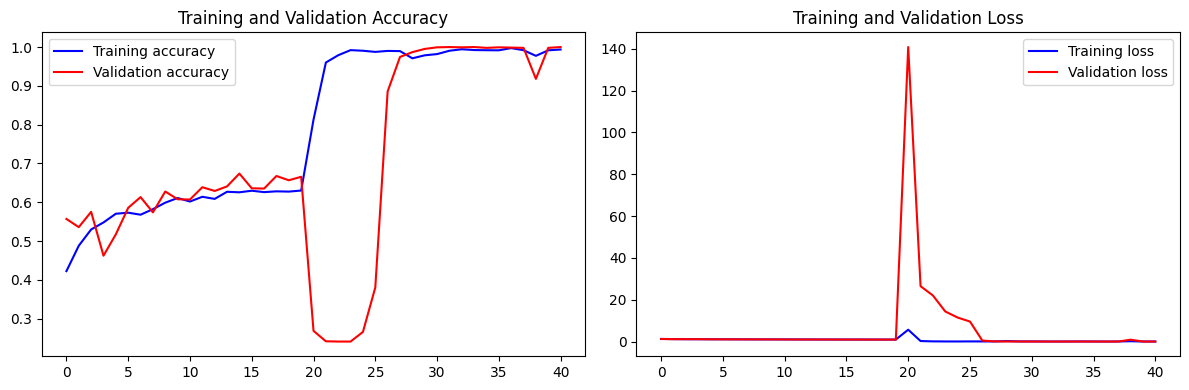

In [13]:
def plot_training_history(history1, history2=None, start_epoch=0):
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']
    
    if history2:
        acc += history2.history['accuracy']
        val_acc += history2.history['val_accuracy']
        loss += history2.history['loss']
        val_loss += history2.history['val_loss']
    
    epochs = range(start_epoch, len(acc) + start_epoch)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_stage1, history_stage2)